                                                                                                        Colegio Santa Ana
                                                                                                              5º 2º
                                                                                                        Sebastián Andrés
## Toma de datos:

> Los datos tienen la forma $Datos_{j,i}$, siendo $j$ las columnas e $i$ las filas/registros. 

> Luego de exportar el archivo .csv con las respuestas de la encuesta y filtrarlo, se le puede añadir a este una cantidad infinita de registros sin alterar significativamente la media (μ) ni la desviación estandar (δ) con la distribución normal / campana de Gauss (dn).

- Para ello se puede tomar para cada columna de datos:

    $μ_j = 1/L * \sum_{i=0}^{L}(Datos_{ji})$
    
    $δ_j = \sqrt(\sum_{i=0}^{L} |μ_j - Datos_{ji}|)$
    
    <i>(siendo L la cantidad de registros) </i>
    
    
- Y calcular en base a ellas, la probabilidad ($P$) de la aparición de un valor $a$ con respecto a $a+1$. Como en una distribución normal esta probabilidad coincide con el área bajo la curva (x 100):


<center>  $P_{j}(a) = 100 \int_{a}^{a+1} dn(a) da => 100 \int_{a}^{a+1} \frac 1{(δ_j*\sqrt(2\pi)} e^-{\frac{x-μ_j}{2δ_j^2}} = 100\frac {1}{2\pi}erf(\frac{x-μ_j}{2δ_j^2}) |_{a}^{a+1}$ </center>

- Así, se pueden tomar números enteros aleatorios ($rnd$) de rango (0, $k$), sirviendo una $k$ grande para mejorar la precisión en casos de gran $δ_j$, y clasificarlos dentro de otro rango previsto con mínimos y máximos determinados por el propio registro o la tendencia tal que $P_{j}(a) > 0.1$.  

### Modo de clasificación:

- Para agrupar cada ($rnd$) hice un vector $R_{j}$ que guarda todas las probabilidades de dentro del rango previsto.

<center> $R_{j} = [{P_{j}(a_1), P_{j}(a_2), ..., P_{j}(a_L)}], a ∈ rango (0,k)$ </center>

- Cuya fórmula reemplace con esta notación para facilitarme la vista.

<center> $R_{j} = \psi_{i=0}^L P_{j}(a_i)$ </center>

- Después, hice otro vector $RAc_{j}$ que es similar a R, pero que va <b>'Ac'</b>umulando los resultados anteriores al que le da en cierta posición $i$. 

<center> $RAc_{j} = \psi_{i=0}^L P_{j}(a_i) + P_j(a_{i-1})$ </center>

<center> (Es decir, si un $R_j$ da [1,5,1], $RAc_j$ quedaría [1, 6, 7] siendo 7 = k)</center>

- A partir de esto, lo único que queda hacer es hacer un algoritmo que clasifique cualquier valor $rnd$ dentro de una de las categorías, cuya probabilidad queda visible en la cantidad de números que incorpora en su grupo (que es cada index del vector):

> <center> Si $rnd <= RAc_{j,i}, rnd ∈ Grupo_i| i = RAc_j^{-1}(RAc_{j,i})$ </center> 
<center> (Por ejemplo, en el caso de arriba si entra un $rnd = 3$, $rnd ∈ Grupo_1$ porque este abarca a todo el rango (1,6))</center>
                                                
                                                       Aclaración: los índices de este caso empiezan en 0.
                                               
### Análisis de eficiencia:

- Determiné la eficiencia del programa en base a comparar la media de la columna inicial ($μ_j^i$) con la media de la columna final (con los agregados) ($μ_j^f$). Mientras menor es esa diferencia, mejor compilación tuvo el programa. En el código, esto se puede ver en la sexta celda con la comparativa $Avg1$ vs $Avg2$.

In [1]:
## Código 
import math
import pandas as pd
import numpy as np

# Matriz de datos
Datos = pd.read_csv("enc4.csv") #
Datos2 = []
print(Datos.head())

                   Marca temporal  ¿Qué edad tiene? (años)  \
0  2020/08/03 8:44:33 p. m. GMT-3                       46   
1  2020/08/03 8:52:04 p. m. GMT-3                       55   
2  2020/08/03 8:58:35 p. m. GMT-3                       17   
3  2020/08/03 9:03:16 p. m. GMT-3                       74   
4  2020/08/03 9:05:53 p. m. GMT-3                       47   

   ¿Cuántas personas viven en su hogar? ¿Tiene agua potable en su domicilio?  \
0                                     3                                   Sí   
1                                     1                                   Sí   
2                                     3                                   Sí   
3                                     2                                   Sí   
4                                     2                                   Sí   

   ¿De dónde obtiene el agua?  \
0  Red pública en la vivienda   
1  Red pública en la vivienda   
2  Red pública en la vivienda   
3  Red pública

In [2]:
# Filtrado y adaptación de datos

dt_edad = Datos["¿Qué edad tiene? (años)"]
for j, edad in enumerate (dt_edad):
    if edad > 100:
        veces = int(edad / 100)
        n_edad = edad - veces * 100
    else:
        n_edad = edad
    dt_edad[j] = n_edad

dt_time = Datos["En el caso de que la tenga, ¿desde qué año esta condición se cumple?"]
for i, rg in enumerate(dt_time):
    if rg < 1900:
        dt = 1900 + rg
    else: 
        dt = rg
    dt_time[i] = dt
    
# Lógica del sum (datos = x)
def S(f, k, i=0, datos=[]):
    ## f = función aplicada ## i = x inicio  ## k = x final
    Accum = 0
    if len(datos) == 0:   
        while i <= k:
            Accum += f(i)
            i+=1
    else:
        for xi in datos:
            Accum += f(xi)
    return Accum

## Mediana y desviación estandar
μ = lambda j: sum(Datos[j])/len((Datos[j]))
def δ(j):
    f = lambda x: abs(μ(j) - x)
    return math.sqrt(S(f, len(Datos[j]), i=0, datos = Datos[j]) / len(Datos[j]))

# Area entre puntos a,b
def P(a, b, col):
    F = lambda x: math.erf((x-μ(col)) / (math.sqrt(2) * δ(col))) / 2
    return abs (F(b) - F(a))

def A(a, col):
    return P(a-1, a, col) * 100

import random 

def tomarR(col, a, b):
    N = list()
    while a != b:
        N.append(A(a, col))
        a += 1
    return N

def minMax(col):
    _min_ = 0
    _max_ = 0
    for n in Datos[col]:
        if n <= _min_:
            _min_ = n
        elif n >= _max_:
            _max_ = n        
    return _min_, _max_

a = lambda col: minMax(col)[0] 
b = lambda col: minMax(col)[1]
R = lambda col: tomarR(col, a(col), b(col))

def k(j):
    print ("kj: ", sum(R(j)))
    return sum(R(j))

def grupo(rnd, R_):
    R_ac = list()           # [r + R_[i-1] for i, r in enumerate(R_)]
    ct = 0
    for r in R_:
        R_ac.append(ct+int(r))
        ct = ct + int(r)
    # print("R_ac = ", R_ac)
    for r in R_ac:
        if rnd <= r:
            # print ("{} <= {} , devuelvo {}".format(rnd, r, R_ac.index(r)))
            return R_ac.index(r)
    return len(R_ac)-1

def LlenarColumna (col, Δ):
    print ("\n> Llenando columna {}".format(col))
    R_ = tomarR(col, a(col), b(col))
    print("R_: ", R_)
    inicio = len(Datos[col])
    Datos[col] = Datos[col].dropna()
    for i in range(Δ):
        rnd = random.randint(0, 100) #int(k(col))
        #print ("rnd({}) = {}".format(i, rnd))
        Datos[col][inicio + i] = grupo(rnd, R_)  # .append()
        #print("Datos[{},{}] = {}".format(col, inicio+i,grupo(rnd,R_)))
    print ("sum(R_): ", sum(R_))
    print ("Columna. ", col)
    #print ("Datos2[{}] = {}".format(len(Datos2), Datos[col].to_list()))
    Datos2.append(Datos[col].to_list())
    
    print("Datos resultado: ", Datos[col].to_list())
    return Datos[col]

DatosCol = ['Marca temporal',
           '¿Qué edad tiene? (años)',
           '¿Cuántas personas viven en su hogar?',
           '¿Tiene agua potable en su domicilio?', '¿De dónde obtiene el agua?',
           'En el caso de que la tenga, ¿desde qué año esta condición se cumple?',
           '¿Consume agua potable o compra agua mineral?',
           'De entre las siguientes categorías, ¿cuál diría que es con la que usted consume más agua?',
           'De los siguientes factores, ¿cuál diría que es más determinante con respecto a los problemas de acceso al agua?',
           'En promedio, ¿cuántos minutos ocupa para bañarse?',
           '¿Tiene ducha de alto o bajo flujo?',
           '¿Cuántos minutos diarios deja correr el agua para la limpieza con (lavabo, ropa, trapos, etc.)? ',
           '¿Cómo lava los platos?',
           '¿Tiene un sistema de aguas grises instalado?',
           '¿Tiene un barril pluvial?',
           '¿Tiene relevancia la cuestión ambiental en su voto?',
           '¿En qué provincia reside?',
           '(En el caso de que resida en Buenos Aires) ¿A qué distancia se encuentra respecto a CABA (km)? (puede tomar como referencia al Congreso)',
           '¿Tiene auto?',
           "En caso de que lo tenga y exceptuando esta coyuntura de la pandemia, ¿cuántos kilometros por día recorre?",
           'Si tiene pileta, ¿cada cuántos meses la vuelve a llenar? (en el caso que tenga filtro, conteste cero)',
           '¿Recicla? (plástico, latas, cartón, telas, etc.)',
           '¿Quién cree que es el grupo socioeconómico que más contamina?',
           'Y, ¿qué actividad cree que consume más?',
           '¿Cuánta carne por semana consume? (kg)',
           'Siendo honesto/a, ¿cuál de los siguientes términos es su prioridad?',
           '¿La suma de los ingresos de su hogar supera el umbral de la CBT según la cantidad de los miembros? (1 persona : $14.178; 2 personas : $28.356; 3 personas : $34.878; 4 personas : $43.811; 5 personas : $46.079)',
           '¿A qué grupo pertenece?',
           '¿Cuántos días cree que podría vivir una persona de un país afectado, con el agua que se usa en 15 minutos de ducha?',
           '¿En quién confía más para revertir la situación y cuál cree que es la solución?',
           'Para finalizar, ¿cree que su consumo es racional?']

C:\Users\Sebastian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Sebastian\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [3]:
## Datos reales de la encuesta: 
for i, d in enumerate (Datos):
    print ("Datos : ", DatosCol[i])
    print (Datos[DatosCol[i]].to_list())
    print ()

Datos :  Marca temporal
['2020/08/03 8:44:33 p.\xa0m. GMT-3', '2020/08/03 8:52:04 p.\xa0m. GMT-3', '2020/08/03 8:58:35 p.\xa0m. GMT-3', '2020/08/03 9:03:16 p.\xa0m. GMT-3', '2020/08/03 9:05:53 p.\xa0m. GMT-3', '2020/08/03 9:09:03 p.\xa0m. GMT-3', '2020/08/03 9:26:25 p.\xa0m. GMT-3', '2020/08/03 9:58:28 p.\xa0m. GMT-3', '2020/08/03 10:40:17 p.\xa0m. GMT-3', '2020/08/03 11:08:06 p.\xa0m. GMT-3', '2020/08/03 11:23:30 p.\xa0m. GMT-3', '2020/08/04 1:04:27 a.\xa0m. GMT-3', '2020/08/04 12:11:55 p.\xa0m. GMT-3', '2020/08/04 12:20:15 p.\xa0m. GMT-3', '2020/08/04 12:30:19 p.\xa0m. GMT-3', '2020/08/04 12:39:43 p.\xa0m. GMT-3', '2020/08/04 12:40:01 p.\xa0m. GMT-3', '2020/08/04 12:40:29 p.\xa0m. GMT-3', '2020/08/04 12:46:04 p.\xa0m. GMT-3', '2020/08/04 1:32:45 p.\xa0m. GMT-3', '2020/08/04 2:04:28 p.\xa0m. GMT-3', '2020/08/04 5:56:33 p.\xa0m. GMT-3', '2020/08/04 11:20:44 p.\xa0m. GMT-3', '2020/08/05 7:51:36 p.\xa0m. GMT-3', '2020/08/06 4:33:36 p.\xa0m. GMT-3']

Datos :  ¿Qué edad tiene? (años)
[46, 

In [4]:
## Dado que no todos los registros están en formato numérico, hay que transformarlos.

# Pasar categorías str a números 
def Transf(col):
    NDC = list() 
    categorias = [] 
    for el in Datos[col]:
        if el not in categorias:
            categorias.append(el)
        categoria = categorias.index(el)+1
        NDC.append(categoria)
    return categorias, NDC

# Ejemplo
# Datos["¿A qué grupo pertenece?"] = Transf("¿A qué grupo pertenece?")[1]
# print(Datos["¿A qué grupo pertenece?"])

categorias = []
col_categoria = [3,4,6,7,8,9,10,12,13,14,15,16,18,21,22,23,25,26,27,29,30] # 27
for n in col_categoria:
    g, Datos[DatosCol[n]] = Transf(DatosCol[n])
    categorias.append(g)
    
print(Datos.dtypes)

Marca temporal                                                                                                                                                                                                       object
¿Qué edad tiene? (años)                                                                                                                                                                                               int64
¿Cuántas personas viven en su hogar?                                                                                                                                                                                  int64
¿Tiene agua potable en su domicilio?                                                                                                                                                                                  int64
¿De dónde obtiene el agua?                                                                                              

In [5]:
# Tomar datos random según la media

def TodosIguales(lista):
    ## Verifica si todos los registros del vector son iguales
    rt = True
    nl = [lista[0]]
    for el in lista:
        if el not in lista:
            rt = False
    return rt

def ToInt(lista):
    ## Transforma a lista numérica a la lista de entrada
    return pd.to_numeric(lista)

# Columnas cuyo registro es (Sí o No)
col_binarias = [3,6,10,13,14,15,18,21,24,25,28,30]
for j, lbl in enumerate(DatosCol[1:]):
    if j+1 not in col_binarias:
        try:
            Datos[lbl] = ToInt(Datos[lbl])
        except Exception:
            print("< j : {} omitida".format(j))

ListaExcepciones = []
clean_nan = lambda lista: [x for x in lista if (math.isnan(x) == False)]

for j, lbl in enumerate(DatosCol[1:]):
    print("\n {}. ".format(j),lbl)
    _bool_ = False
    # print(Datos[lbl])
    if True: #  j+1 not in col_binarias and TodosIguales(Datos[lbl]) == False
        try:    
            Avg1 = Datos[lbl].mean()
            LlenarColumna(lbl, 26)
            Avg2 = μ(lbl)
            print ()
            print ("Avg1 {} vs Avg2 {} ".format(Avg1, Avg2))
        
        except ZeroDivisionError:
            _bool_ = True
            inicio = len(Datos[lbl])
            Datos2.append([]) # en posicion j
            for n in range(50):
                Datos[lbl][inicio+n] = Datos[lbl][0]
                Datos2[j].append(1)
            print ("> 100% (=)")
        
        except Exception as e:
            if _bool_ == False:    
                print("> Excepción {} en ".format(e), j+1) # o j + 1
                ListaExcepciones.append(j+1)
                Datos2.append([])
                Datos2[j] = [1 for n in range(50)]


 0.  ¿Qué edad tiene? (años)

> Llenando columna ¿Qué edad tiene? (años)
R_:  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.3306690738754696e-14, 2.1094237467877974e-13, 1.3711254354120683e-12, 8.504308368628699e-12, 4.9815707114930774e-11, 2.7525759449531506e-10, 1.434924401522153e-09, 7.057676665311874e-09, 3.275188453777389e-08, 1.4340147402869263e-07, 5.923992296708036e-07, 2.308978214182744e-06, 8.491227937446055e-06, 2.9462344280917208e-05, 9.645195443441779e-05, 0.00029792192181576915, 0.0008682450600594471, 0.0023874336859019962, 0.006193984611463366, 0.015162100626653352, 0.03501867264487091, 0.07631178466187549, 0.15690460827919583, 0.30439144687936515, 0.5571630530256055, 0.9622451162850376, 1.5679891306331017, 2.410763744016914, 3.4972029155261875, 4.786762213636791, 6.1818425960970815, 7.532675885191245, 8.660361308872119, 9.394598692377881, 9.615591521352423, 9.286014253615688, 8.46132211046548, 7.274490583200155, 5.900955102292893, 4.51645045994822

C:\Users\Sebastian\Anaconda3\lib\site-packages\ipykernel_launcher.py:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\Sebastian\Anaconda3\lib\site-packages\ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


> 100% (=)

 3.  ¿De dónde obtiene el agua?

> Llenando columna ¿De dónde obtiene el agua?
> 100% (=)

 4.  En el caso de que la tenga, ¿desde qué año esta condición se cumple?

> Llenando columna En el caso de que la tenga, ¿desde qué año esta condición se cumple?
R_:  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0

Avg1 1.76 vs Avg2 1.3529411764705883 

 6.  De entre las siguientes categorías, ¿cuál diría que es con la que usted consume más agua?

> Llenando columna De entre las siguientes categorías, ¿cuál diría que es con la que usted consume más agua?
> 100% (=)

 7.  De los siguientes factores, ¿cuál diría que es más determinante con respecto a los problemas de acceso al agua?

> Llenando columna De los siguientes factores, ¿cuál diría que es más determinante con respecto a los problemas de acceso al agua?
R_:  [2.7273394486895253, 15.856610733075089, 36.040476918762224, 32.22678038956231]
sum(R_):  86.85120749008914
Columna.  De los siguientes factores, ¿cuál diría que es más determinante con respecto a los problemas de acceso al agua?
Datos resultado:  [1, 1, 1, 1, 1, 1, 2, 3, 1, 4, 2, 4, 1, 2, 4, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 0, 2, 2, 3, 3, 2, 2, 3, 3, 0, 3, 3, 2, 3, 0, 1, 2, 3, 3, 2, 2]

Avg1 1.88 vs Avg2 2.0392156862745097 

 8.  En promedio, ¿cuántos minutos ocupa para ba

sum(R_):  92.96213656351873
Columna.  Y, ¿qué actividad cree que consume más?
Datos resultado:  [1, 2, 3, 1, 1, 4, 2, 2, 1, 1, 2, 3, 1, 2, 2, 1, 1, 1, 1, 1, 1, 2, 1, 4, 2, 2, 2, 3, 3, 0, 3, 2, 2, 3, 2, 3, 2, 1, 0, 1, 2, 3, 2, 1, 1, 3, 0, 3, 3, 3, 2]

Avg1 1.72 vs Avg2 1.8627450980392157 

 23.  ¿Cuánta carne por semana consume? (kg)

> Llenando columna ¿Cuánta carne por semana consume? (kg)
R_:  [nan, nan, nan, nan, nan]
> Excepción cannot convert float NaN to integer en  24

 24.  Siendo honesto/a, ¿cuál de los siguientes términos es su prioridad?

> Llenando columna Siendo honesto/a, ¿cuál de los siguientes términos es su prioridad?
R_:  [2.2309574934815557, 27.537807083825083]
sum(R_):  29.768764577306637
Columna.  Siendo honesto/a, ¿cuál de los siguientes términos es su prioridad?
Datos resultado:  [1, 2, 2, 1, 1, 2, 2, 2, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

Avg1 1.36 vs Avg2 1.15686274509

In [6]:
# Registros no manipulables por el algoritmo de forma automática
print ("> Lista Excepciones: ", ListaExcepciones)
for n in ListaExcepciones:
    print(DatosCol[n])

> Lista Excepciones:  [11, 17, 19, 20, 24, 28]
¿Cuántos minutos diarios deja correr el agua para la limpieza con (lavabo, ropa, trapos, etc.)? 
(En el caso de que resida en Buenos Aires) ¿A qué distancia se encuentra respecto a CABA (km)? (puede tomar como referencia al Congreso)
En caso de que lo tenga y exceptuando esta coyuntura de la pandemia, ¿cuántos kilometros por día recorre?
Si tiene pileta, ¿cada cuántos meses la vuelve a llenar? (en el caso que tenga filtro, conteste cero)
¿Cuánta carne por semana consume? (kg)
¿Cuántos días cree que podría vivir una persona de un país afectado, con el agua que se usa en 15 minutos de ducha?


In [7]:
## Incorporar columnas no posibles de analizar automáticamente

listaCol = list()
lista_μ = list()
lista_δ = list()

for n in ListaExcepciones:
    
    Datos[DatosCol[n]] = Datos[DatosCol[n]].dropna()
    
    #print()
    
    data = Datos[DatosCol[n]].dropna()
    listaCol.append(DatosCol[n])
    
    Datos2[n-1] = data.to_list()
    
    print("> {}: {}".format(DatosCol[n], Datos2[n]))
    
    lista_μ.append(sum(data)/(len(data)+1))
    f = lambda x: abs(lista_μ[-1] - x)
    lista_δ.append(math.sqrt(S(f, len(data), i=0, datos = data) / len(data)))
    
    # print (sum(data)/len((data)))
    # print ()
    
print("> Lista U", lista_μ)
print("> Lista O ", lista_δ)

> ¿Cuántos minutos diarios deja correr el agua para la limpieza con (lavabo, ropa, trapos, etc.)? : [1, 1, 1, 1, 1, 1, 1, 2, 1, 3, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 1, 2, 1, 1, 1, 2, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2]
> (En el caso de que resida en Buenos Aires) ¿A qué distancia se encuentra respecto a CABA (km)? (puede tomar como referencia al Congreso): [1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
> En caso de que lo tenga y exceptuando esta coyuntura de la pandemia, ¿cuántos kilometros por día recorre?: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
> Si tiene pileta, ¿cada cuántos meses la vuelve a llenar? (en el caso que tenga filtro, conteste cero): [1, 1, 2, 1, 3, 2, 2, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 2, 3, 2, 2, 3, 1, 1, 1, 2, 2, 2,

In [8]:
# Añadir a listas

s_ListaExcepciones = [DatosCol[n] for n in ListaExcepciones] # ListaExcepciones[3:]

def _P(a, b, col):
    F = lambda x: math.erf((x-lista_μ[s_ListaExcepciones.index(col)]) / (math.sqrt(2) * lista_δ[s_ListaExcepciones.index(col)])) / 2
    return abs (F(b) - F(a))

def _A(a, col):
    return _P(a-1, a, col) * 100

def _tomarR(col, a, b):
    N = list()
    while a != b:
        N.append(_A(a, col))
        a += 1
    return N

def _LlenarColumna (col, Δ):
    print ("\n> Llenando columna {}".format(col))
    for i, c in enumerate (Datos[col]):
        try:
            Datos[col, i] = int(c)
        except Exception:
            pass
    R_ = _tomarR(col, a(col), b(col))
    print("R_: ", R_)
    for i in range(Δ):
        rnd = random.randint(0, 100) #int(k(col))
       # print ("rnd({}) = {}".format(i, rnd))
        Datos2[DatosCol.index(col)].append(grupo(rnd, R_))
      # Datos[col][inicio + i] = grupo(rnd, R_)  # .append()
       # print("Datos[{},{}] = {}".format(col, inicio+i,grupo(rnd,R_)))
    # print ("sum(R_): ", sum(R_))
    # print ("Columna. ", col)
    # Datos2[DatosCol.index(col)] = Datos[col].to_list()
    print ("Datos Col retorno: ", Datos[col].to_list())
    return Datos[col]

for j in ListaExcepciones:
    lbl = DatosCol[j]
    Avg1 = Datos[lbl].mean()
    print("> Index: ", DatosCol.index(lbl))
    Datos[lbl] = _LlenarColumna(lbl, 26)
    Avg2 = lista_μ[s_ListaExcepciones.index(lbl)]
    print ("Avg1 {} vs Avg2 {} ".format(Avg1, Avg2))

> Index:  11

> Llenando columna ¿Cuántos minutos diarios deja correr el agua para la limpieza con (lavabo, ropa, trapos, etc.)? 
R_:  [7.676869140382792e-08, 2.472612947723718e-07, 7.664468726353846e-07, 2.286451972199899e-06, 6.564421139998444e-06, 1.8137829216335888e-05, 4.82312919380945e-05, 0.00012343189094154994, 0.00030400515632078573, 0.0007205925563302795, 0.001643819071106556, 0.003608891620454635, 0.007625167724251147, 0.015505323975312235, 0.03034368437102586, 0.05714943430061292, 0.1035885709368356, 0.1807041592973735, 0.3033758239255835, 0.4901741515324909, 0.7622133596183078, 1.1406686628936347, 1.6428554372638848, 2.2771736382869836, 3.037735603656788, 3.8999665281733433, 4.818689287854022, 5.729993727022492, 6.55747409914561, 7.222312292726945, 7.655493725410281, 7.809575364166234, 7.66723745808309, 7.244487735280184, 6.587698459185884, 5.765234611992732, 4.85576292052265, 3.9360004925771355, 3.0705060065643055, 2.305270247603086, 1.6656769169388852, 1.1582882516244897

In [9]:
import numpy as np
nan = np.nan
DatosResultado = Datos2
df = pd.DataFrame (DatosResultado).transpose()
df.columns = DatosCol[1:]

In [18]:
for j, c in enumerate (DatosResultado):
    print ("{}, ".format(j),DatosCol[j+1])   
    print (DatosResultado[j])
    if True:#DatosCol[j] not in s_ListaExcepciones:
        print ("μ(c) = ", sum(c)/len(c))
    else:
        print ("(EX) μ(c) = ", lista_μ[s_ListaExcepciones.index(DatosCol[j])])
    print()

0,  ¿Qué edad tiene? (años)
[46, 55, 17, 74, 47, 17, 14, 17, 70, 37, 28, 70, 14, 31, 60, 68, 68, 68, 60, 57, 29, 61, 47, 49, 56, 46, 50, 47, 44, 50, 73, 49, 48, 49, 41, 47, 52, 42, 46, 43, 44, 52, 42, 45, 47, 43, 44, 47, 45, 47]
μ(c) =  46.86

1,  ¿Cuántas personas viven en su hogar?
[3, 1, 3, 2, 2, 5, 4, 3, 2, 4, 4, 3, 4, 2, 4, 2, 2, 2, 1, 1, 2, 4, 2, 5, 2, 4, 4, 2, 2, 2, 4, 2, 2, 3, 2, 1, 3, 4, 2, 3, 3, 3, 3, 3, 3, 2, 4, 4, 4, 4, 2]
μ(c) =  2.823529411764706

2,  ¿Tiene agua potable en su domicilio?
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
μ(c) =  1.0

3,  ¿De dónde obtiene el agua?
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
μ(c) =  1.0

4,  En el caso de que la tenga, ¿desde qué año esta condición se cumple?
[1974, 1997, 1950, 1965, 1970, 1920, 2008, 1930, 1965, 1940, 

In [19]:
df

,¿Qué edad tiene? (años),¿Cuántas personas viven en su hogar?,¿Tiene agua potable en su domicilio?,¿De dónde obtiene el agua?,"En el caso de que la tenga, ¿desde qué año esta condición se cumple?",¿Consume agua potable o compra agua mineral?,"De entre las siguientes categorías, ¿cuál diría que es con la que usted consume más agua?","De los siguientes factores, ¿cuál diría que es más determinante con respecto a los problemas de acceso al agua?","En promedio, ¿cuántos minutos ocupa para bañarse?",¿Tiene ducha de alto o bajo flujo?,...,"¿Recicla? (plástico, latas, cartón, telas, etc.)",¿Quién cree que es el grupo socioeconómico que más contamina?,"Y, ¿qué actividad cree que consume más?",¿Cuánta carne por semana consume? (kg),"Siendo honesto/a, ¿cuál de los siguientes términos es su prioridad?",¿La suma de los ingresos de su hogar supera el umbral de la CBT según la cantidad de los miembros? (1 persona : $14.178; 2 personas : $28.356; 3 personas : $34.878; 4 personas : $43.811; 5 personas : $46.079),¿A qué grupo pertenece?,"¿Cuántos días cree que podría vivir una persona de un país afectado, con el agua que se usa en 15 minutos de ducha?",¿En quién confía más para revertir la situación y cuál cree que es la solución?,"Para finalizar, ¿cree que su consumo es racional?"
0,46.0,3.0,1.0,1.0,1974.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,0.5,1.0,1.0,1.0,2.0,1.0,1.0
1,55.0,1.0,1.0,1.0,1997.0,2.0,1.0,1.0,1.0,2.0,...,1.0,2.0,2.0,1.0,2.0,2.0,1.0,4.0,2.0,1.0
2,17.0,3.0,1.0,1.0,1950.0,1.0,1.0,1.0,2.0,1.0,...,2.0,2.0,3.0,2.0,2.0,1.0,1.0,5.0,2.0,2.0
3,74.0,2.0,1.0,1.0,1965.0,1.0,1.0,1.0,3.0,1.0,...,1.0,2.0,1.0,0.5,1.0,1.0,1.0,3.0,2.0,1.0
4,47.0,2.0,1.0,1.0,1970.0,2.0,1.0,1.0,4.0,2.0,...,3.0,2.0,1.0,0.3,1.0,1.0,1.0,4.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,28.0,NaN
73,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5.0,NaN,NaN,NaN,2.0,NaN,NaN,NaN,149.0,NaN
74,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,NaN,NaN,NaN,2.0,NaN,NaN,NaN,19.0,NaN
75,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,11.0,NaN,NaN,NaN,2.0,NaN,NaN,NaN,25.0,NaN


In [20]:
categorias

[['Sí'],
 ['Red pública en la vivienda'],
 ['Agua mineral', 'Agua potable'],
 ['Agua Interna (consumida en las actividades domésticas)'],
 ['Pobreza (falta de infraestructura)',
  'Contaminación industrial',
  'Corrupción',
  'Cantidad de agua dulce insuficiente'],
 [10, 20, 5, 15, 8],
 ['Bajo', 'Alto'],
 ['A mano', 'Lavavajillas antiguo', 'Lavavajillas eficiente'],
 ['No', 'Sí'],
 ['No', 'Si'],
 ['No', 'Sí'],
 ['Buenos Aires', 'Santa Fe', 'Córdoba', 'Misiones'],
 ['Sí', 'No'],
 ['Parcialmente', 'No', 'Todo'],
 ['Clase media', 'Clase baja', 'Clase alta'],
 ['Minera', 'Industrial', 'Agropecuaria', 'Comercio'],
 ['Ahorrar agua', 'Ahorrar dinero'],
 ['Si', 'No'],
 ['Clase media', 'Clase baja'],
 ['Fortalecer al sector privado', 'Fortalecer al Estado'],
 ['Sí', 'No']]

In [21]:
## Regresor : 
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

# Columnas de interes
c1 = 1
c2 = 9
Tipo = "Regresión Múltiple" # / "Regresión logística"

X = Datos[[DatosCol[c1]]][:25]
Y = Datos[[DatosCol[c2]]][:25]

if Tipo == "Regresión Múltiple":
    
    modelo = linear_model.LinearRegression()
    modelo.fit(X, Y)

    # Coef
    print ("> Coeficientes: ", modelo.coef_)

    # Comparación
    Fx = modelo.predict(X)
    Error = r2_score(Y, Fx)
    print ("> Error: ", Error)

else:
    
    modelo = LogisticRegression()
    modelo.fit(X, Y)
    
    Fx = modelo.predict(X)
    
    print ("Equivalencias: ", np.mean(Fx == Y))
    
    
# Elegir x de un input y ver resultado
# modelo.predict(X)

> Coeficientes:  [[-0.01026112]]
> Error:  0.029527129915683736


### Formar grupos semejantes (KMedias):

> Utilizando el algoritmo de Lloyd, se pueden formar n_grupos $S$ de los datos de una columna, generando centroides/medias ($μ_j$) en posiciones aleatorias que se adaptan a los datos y minimizan las varianzas de cada valor a todos ellos.

> La forma en que se agrupan en cada $S$ es minimizando esta suma por cada columna $j$:

<center>$\frac{arg min}{S}\sum_{i=1}^{n_grupos}\sum_{Datos_{ji} ∈ S}^{L} ||Datos_{ji} - μ_j||^2$</center>

> Calculando automáticamente los nuevos centroides $μ_j$ de este modo (S_i es un vector con c/ grupo S):

<center>$μ_j = \frac{1}{S_i}\sum_{Datos_{ji} ∈ S}Datos_{ji}$</center>


In [22]:
## Klustering
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Columnas de interes
c1 = 1
c2 = 9
n_grupos = 3 

ndf = Datos[[DatosCol[c1], DatosCol[c2]]][:25]

kmeans = KMeans(n_clusters = n_grupos, n_jobs = -1).fit(ndf)
print ("> Categorías Kmean", kmeans.labels_) # Clasificaciones a las que se incorpora cada input

print("> Centros de c/ cluster", kmeans.cluster_centers_)

# Pudiendo predecir la categoría de nuevas variables con
# kmeans.predict(ndf2), ndf2 != ndf1

> Categorías Kmean [0 0 1 2 0 1 1 1 2 0 1 2 1 1 2 2 2 2 2 0 1 2 0 0 0]
> Centros de c/ cluster [[49.25        2.375     ]
 [20.875       3.25      ]
 [66.55555556  3.22222222]]


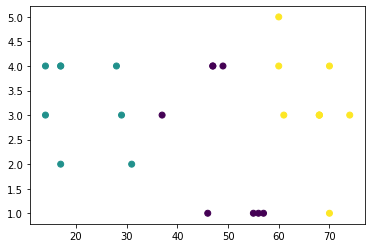

In [23]:
# Gráfico de clusters:
plt.scatter(ndf[DatosCol[c1]], ndf[DatosCol[c2]], c=kmeans.labels_)
plt.show()

In [24]:
df2 = pd.DataFrame(Datos2).transpose()
print (df2)
df2.to_excel("50_Registros.xlsx")

      0    1    2    3       4    5    6    7    8    9   ...    20   21   22  \
0   46.0  3.0  1.0  1.0  1974.0  1.0  1.0  1.0  1.0  1.0  ...   1.0  1.0  1.0   
1   55.0  1.0  1.0  1.0  1997.0  2.0  1.0  1.0  1.0  2.0  ...   1.0  2.0  2.0   
2   17.0  3.0  1.0  1.0  1950.0  1.0  1.0  1.0  2.0  1.0  ...   2.0  2.0  3.0   
3   74.0  2.0  1.0  1.0  1965.0  1.0  1.0  1.0  3.0  1.0  ...   1.0  2.0  1.0   
4   47.0  2.0  1.0  1.0  1970.0  2.0  1.0  1.0  4.0  2.0  ...   3.0  2.0  1.0   
..   ...  ...  ...  ...     ...  ...  ...  ...  ...  ...  ...   ...  ...  ...   
72   NaN  NaN  NaN  NaN     NaN  NaN  NaN  NaN  NaN  NaN  ...   5.0  NaN  NaN   
73   NaN  NaN  NaN  NaN     NaN  NaN  NaN  NaN  NaN  NaN  ...   5.0  NaN  NaN   
74   NaN  NaN  NaN  NaN     NaN  NaN  NaN  NaN  NaN  NaN  ...   3.0  NaN  NaN   
75   NaN  NaN  NaN  NaN     NaN  NaN  NaN  NaN  NaN  NaN  ...  11.0  NaN  NaN   
76   NaN  NaN  NaN  NaN     NaN  NaN  NaN  NaN  NaN  NaN  ...   6.0  NaN  NaN   

     23   24   25   26   27

In [25]:
DatosCol

['Marca temporal',
 '¿Qué edad tiene? (años)',
 '¿Cuántas personas viven en su hogar?',
 '¿Tiene agua potable en su domicilio?',
 '¿De dónde obtiene el agua?',
 'En el caso de que la tenga, ¿desde qué año esta condición se cumple?',
 '¿Consume agua potable o compra agua mineral?',
 'De entre las siguientes categorías, ¿cuál diría que es con la que usted consume más agua?',
 'De los siguientes factores, ¿cuál diría que es más determinante con respecto a los problemas de acceso al agua?',
 'En promedio, ¿cuántos minutos ocupa para bañarse?',
 '¿Tiene ducha de alto o bajo flujo?',
 '¿Cuántos minutos diarios deja correr el agua para la limpieza con (lavabo, ropa, trapos, etc.)? ',
 '¿Cómo lava los platos?',
 '¿Tiene un sistema de aguas grises instalado?',
 '¿Tiene un barril pluvial?',
 '¿Tiene relevancia la cuestión ambiental en su voto?',
 '¿En qué provincia reside?',
 '(En el caso de que resida en Buenos Aires) ¿A qué distancia se encuentra respecto a CABA (km)? (puede tomar como referen